In [5]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
import pandas as pd

from pathlib import Path

In [8]:
# Folder path
path = Path("../data/selected")

# Load data (already split)
X_train = pd.read_csv(path / "X_train_selected.csv")
y_train = pd.read_csv(path / "y_train.csv")


print(X_train.shape)

(1934, 14)


In [11]:
RANDOM_STATE = 42
CV_SPLITS = 5
SEARCH_ITER = 20
SCORING = "roc_auc_ovr"  # chosen because we will tune threshold later; could be recall_macro or f1_macro

# The pipeline with forward feature selection
pipe = Pipeline(
    steps=[
        (
            "feature_selection",
            SequentialFeatureSelector(
                estimator=SVC(probability=True, random_state=RANDOM_STATE),
                direction="forward",
                # n_features_to_select="auto",
                scoring=SCORING,
                cv=CV_SPLITS,
                n_jobs=-1,
            ),
        ),
        (
            "svm",
            SVC(probability=True, random_state=RANDOM_STATE),
        ),
    ]
)

# Define the hyperparameter search space (still for the final SVM)
search_space = {
    "svm__C": Real(1e-3, 1e3, prior="log-uniform"),
    "svm__gamma": Real(1e-4, 1e1, prior="log-uniform"),
    "svm__kernel": Categorical(["rbf", "linear"]),
    "feature_selection__n_features_to_select": Integer(5, X_train.shape[1] - 1),
}

# Stratified CV for the outer Bayes search
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Bayesian search wrapper
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_space,
    n_iter=SEARCH_ITER,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE,
    verbose=0,
)

In [12]:
import warnings

warnings.filterwarnings("ignore")
bayes_search.fit(X_train, y_train)

best_model = bayes_search.best_estimator_

In [18]:
print("Mean score:", bayes_search.best_score_)
print("Best params:", bayes_search.best_params_)

Mean score: 0.9329635895234005
Best params: OrderedDict([('feature_selection__n_features_to_select', 5), ('svm__C', 80.71980758451053), ('svm__gamma', 0.5086437610105452), ('svm__kernel', 'rbf')])


In [19]:
sfs = best_model.named_steps["feature_selection"]

selected_mask = sfs.get_support()
selected_features = X_train.columns[selected_mask]

print("Selected features:", list(selected_features))

Selected features: ['cat__BehavioralProblems_0', 'cat__MemoryComplaints_1', 'num__ADL', 'num__FunctionalAssessment', 'num__MMSE']


In [ ]:
# train on full data

AUC: 0.977953216374269


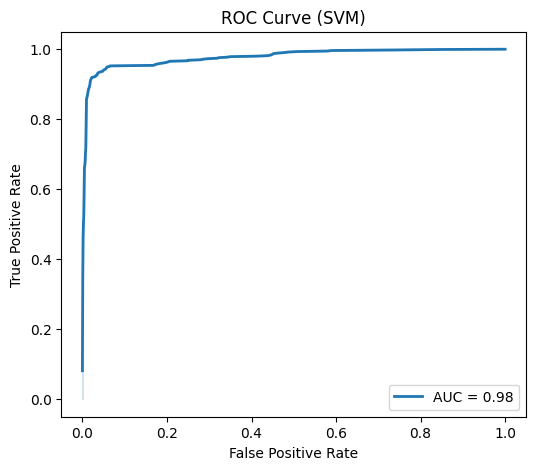

In [14]:
import sys

sys.path.append(".")
sys.path.append("..")

from helpers.roc_utils import plot_roc

auc = plot_roc(best_model, X_train, y_train, title="ROC Curve (SVM)")
print("AUC:", auc)

In [15]:
import pickle

model_path = Path("../data/models")
model_path.mkdir(parents=True, exist_ok=True)

with open(model_path / "SVM_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)